In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchaudio.datasets import SPEECHCOMMANDS
from torchaudio.transforms import MelSpectrogram, MFCC, Resample
from torch.utils.data import DataLoader, random_split
from torchinfo import summary

from sklearn.model_selection import train_test_split
from IPython.display import Audio
from tqdm import tqdm
from librosa.feature import melspectrogram, mfcc


In [2]:
raw_data = SPEECHCOMMANDS('./datasets', download=True)
raw_train_data = SPEECHCOMMANDS('./datasets', subset='training')
raw_valid_data = SPEECHCOMMANDS('./datasets', subset='validation')
raw_test_data = SPEECHCOMMANDS('./datasets', subset='testing')

torch.Size([1, 16000])


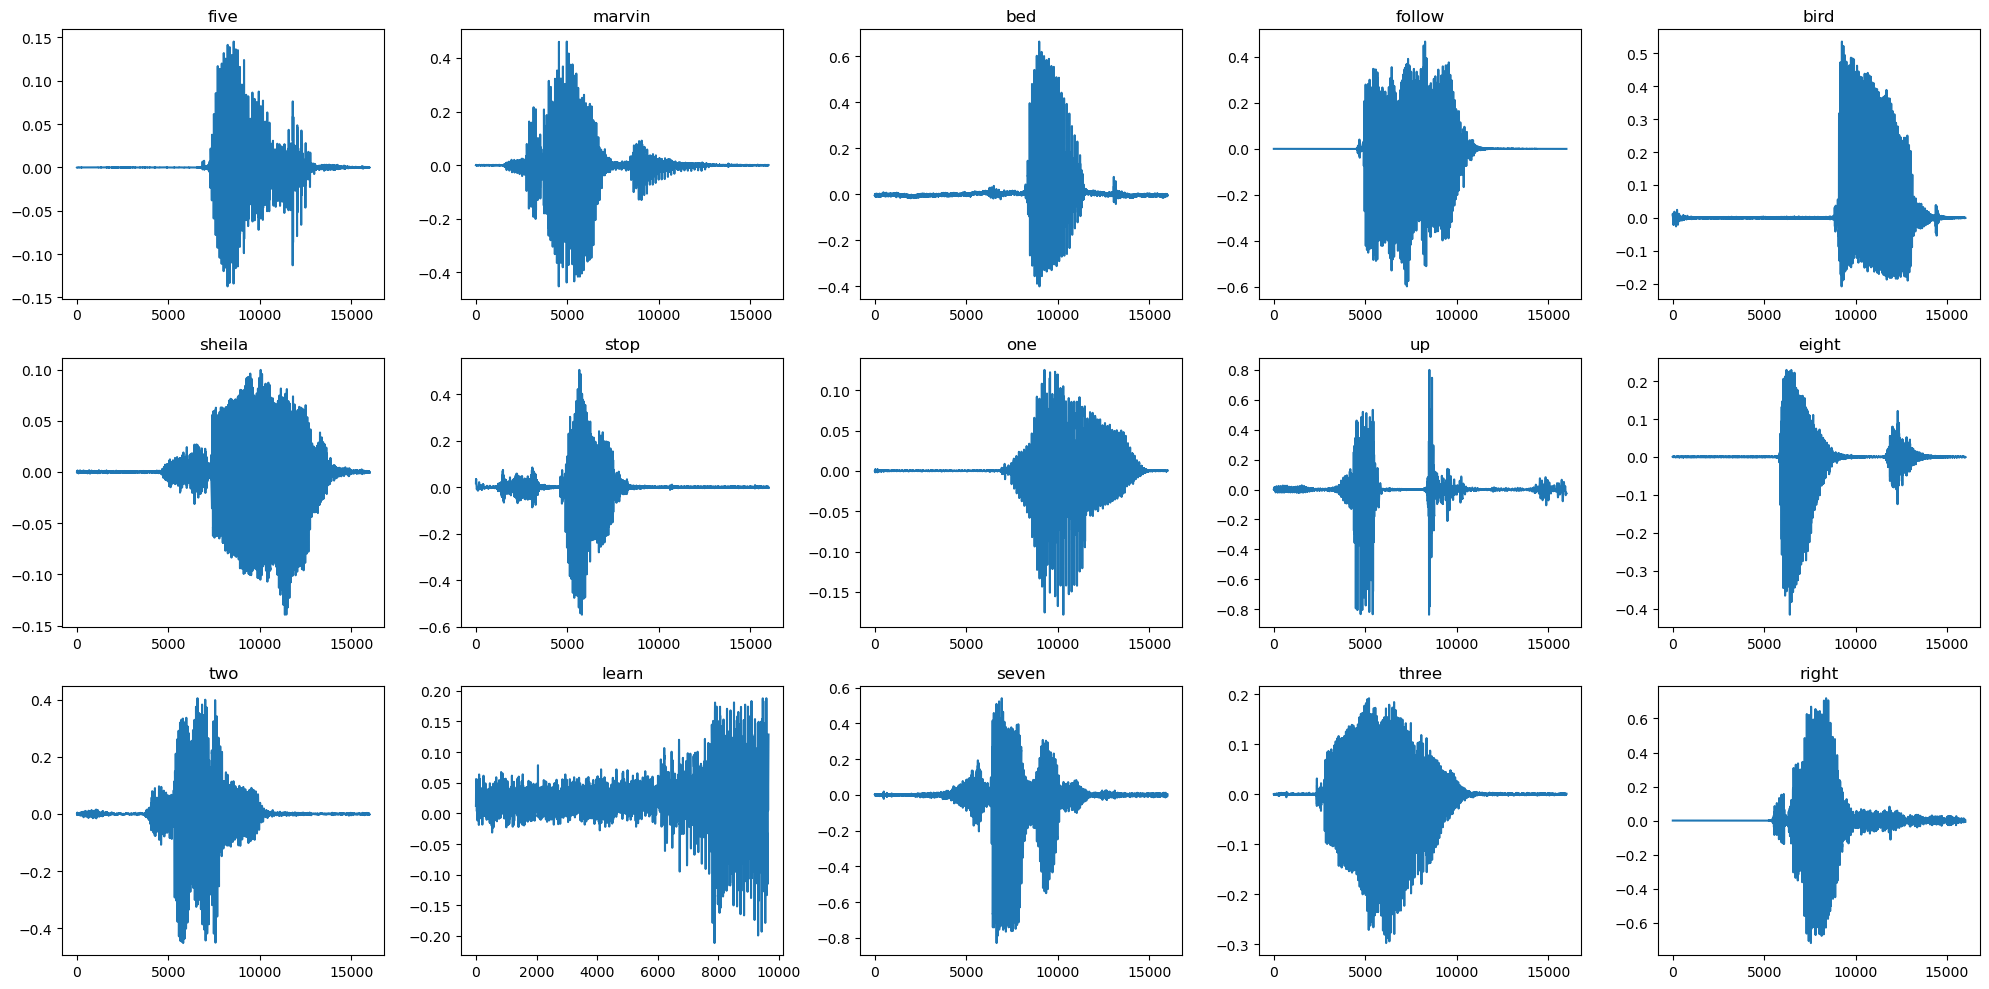

In [3]:
print(raw_train_data[0][0].shape)
sr = raw_train_data[0][1]

label_texts = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

fig, axs = plt.subplots(3, 5, figsize=(20, 10))
for i in range(5):
    idx = np.random.choice(len(raw_train_data))
    axs[0, i].plot(raw_train_data[idx][0].t().numpy())
    axs[0, i].set_title(raw_train_data[idx][2])
    idx = np.random.choice(len(raw_valid_data))
    axs[1, i].plot(raw_valid_data[idx][0].t().numpy())
    axs[1, i].set_title(raw_valid_data[idx][2])
    idx = np.random.choice(len(raw_test_data))
    axs[2, i].plot(raw_test_data[idx][0].t().numpy())
    axs[2, i].set_title(raw_test_data[idx][2])    
plt.tight_layout()
plt.show()

In [4]:
config = {
    'batch_size': 256,
    'shuffle': True,
    'device': torch.device('cuda:2' if torch.cuda.is_available() else 'cpu'),
    'learning_rate': 0.001,
    'epochs': 50,
    'save_path': './models',
}

In [5]:
# padding for raw data
def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

def label_to_index(word):
    return torch.tensor(label_texts.index(word))

def index_to_label(index):
    return label_texts[index]

def collate_fn(batch):
    tensors, targets = [], []
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

def get_MFCC(waveform, sr=8000, n=13):
    m = mfcc(y=waveform.numpy(), sr=sr, n_mfcc=n)
    return torch.tensor(m)

In [6]:
train_dataloader = DataLoader(raw_train_data, batch_size=config['batch_size'], shuffle=config['shuffle'], collate_fn=collate_fn)
valid_dataloader = DataLoader(raw_valid_data, batch_size=config['batch_size'], shuffle=config['shuffle'], collate_fn=collate_fn)
test_dataloader = DataLoader(raw_test_data, batch_size=config['batch_size'], shuffle=config['shuffle'], collate_fn=collate_fn)

# Bi-RNN

In [11]:
class BiRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.fc0 = torch.nn.Linear(input_size * 16, input_size)
        self.rnn = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = torch.nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        # initial hidden states
        hidden = torch.zeros(2 * self.num_layers, x.shape[0], self.hidden_size).to(config['device'])
        x = x.view(x.shape[0], self.input_size * 16)
        # print(x.shape)
        x = self.fc0(x)
        x = x.view(x.shape[0], 1, self.input_size)
        out, _ = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])
        return out

rnn = BiRNN(input_size=64, hidden_size=64, num_layers=2, output_size=35).to(config['device'])
summary(rnn, input_size=(config['batch_size'], 1, 64, 16))

Layer (type:depth-idx)                   Output Shape              Param #
BiRNN                                    [256, 35]                 --
├─Linear: 1-1                            [256, 64]                 65,600
├─RNN: 1-2                               [256, 1, 128]             41,472
├─Linear: 1-3                            [256, 35]                 4,515
Total params: 111,587
Trainable params: 111,587
Non-trainable params: 0
Total mult-adds (M): 28.57
Input size (MB): 1.05
Forward/backward pass size (MB): 0.46
Params size (MB): 0.45
Estimated Total Size (MB): 1.96

In [28]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=config['learning_rate'])

# train
# rnn.train()

transform = torch.nn.Sequential(
    Resample(orig_freq=sr, new_freq=8000)
)

best_loss = 9999999
best_acc = 0

loss_hist = []
acc_hist = []

test_loss_hist = []
test_acc_hist = []
for epoch in range(config['epochs']):
    # train
    rnn.train()
    running_loss = 0.0
    running_acc = 0.0
    for i, (waveform, label) in tqdm(enumerate(train_dataloader)):
        waveform, label = waveform, label.to(config['device'])
        downsampled_waveform = transform(waveform)
        features = get_MFCC(downsampled_waveform, sr=8000, n=64)
        features = features.to(config['device'])
        outputs = rnn(features)
        loss = criterion(outputs, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        running_acc += (predicted == label).sum().item()

    loss_hist.append(running_loss/len(train_dataloader))
    acc_hist.append(running_acc/len(raw_train_data))
    print(f'Epoch {epoch+1}, Loss: {running_loss}, Acc: {running_acc/len(raw_train_data)}')

    rnn.eval()
    running_loss = 0.0
    running_acc = 0.0
    for i, (waveform, label) in enumerate(test_dataloader):
        waveform, label = waveform, label.to(config['device'])
        downsampled_waveform = transform(waveform)
        features = get_MFCC(downsampled_waveform, sr=8000, n=64)
        features = features.to(config['device'])
        outputs = rnn(features)

        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, label)
        running_loss += loss.item()
        running_acc += (predicted == label).sum().item()
    test_loss_hist.append(running_loss/len(test_dataloader))
    test_acc_hist.append(running_acc/len(raw_test_data))
    print(f'Epoch {epoch+1}, Test Loss: {running_loss}, Test Acc: {running_acc/len(raw_test_data)}')
    
    if running_loss < best_loss and running_acc > best_acc:
        best_loss = running_loss
        best_acc = running_acc
        torch.save(rnn.state_dict(), f'{config["save_path"]}/BiRNN.pth')
        


0it [00:00, ?it/s]


TypeError: 'Tensor' object is not callable

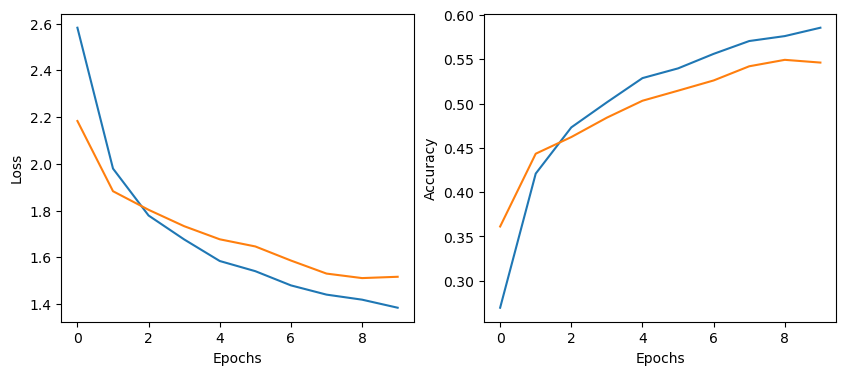

In [13]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))
axs[0].plot(loss_hist)
axs[0].plot(test_loss_hist)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].plot(acc_hist)
axs[1].plot(test_acc_hist)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
plt.show()

# LSTM

In [7]:
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.fc0 = torch.nn.Linear(input_size * 16, input_size)
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=False, dropout=0.3)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        hidden = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(config['device'])
        cell = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(config['device'])
        x = x.view(x.shape[0], self.input_size * 16)
        # print(x.shape)
        x = self.fc0(x)
        x = x.view(x.shape[0], 1, self.input_size)
        out, _ = self.lstm(x, (hidden, cell))
        out = self.fc(out[:, -1, :])
        return out
    
lstm = LSTM(input_size=64, hidden_size=64, num_layers=2, output_size=35).to(config['device'])
summary(lstm, input_size=(config['batch_size'], 1, 64, 16))


Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [256, 35]                 --
├─Linear: 1-1                            [256, 64]                 65,600
├─LSTM: 1-2                              [256, 1, 64]              66,560
├─Linear: 1-3                            [256, 35]                 2,275
Total params: 134,435
Trainable params: 134,435
Non-trainable params: 0
Total mult-adds (M): 34.42
Input size (MB): 1.05
Forward/backward pass size (MB): 0.33
Params size (MB): 0.54
Estimated Total Size (MB): 1.92

In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=config['learning_rate'])

# # train
# lstm.train()

transform = torch.nn.Sequential(
    Resample(orig_freq=sr, new_freq=8000),
    # MFCC(sample_rate=8000, n_mfcc=64)
)

loss_hist = []
acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_loss = 9999999
best_acc = 0

for epoch in range(config['epochs']):
    # train
    lstm.train()
    running_loss = 0.0
    running_acc = 0.0
    for i, (waveform, label) in tqdm(enumerate(train_dataloader)):
        waveform, label = waveform, label.to(config['device'])

        downsampled_waveform = transform(waveform)
        featuress = get_MFCC(downsampled_waveform, sr=8000, n=64)
        featuress = featuress.to(config['device'])
        outputs = lstm(featuress)
        
        loss = criterion(outputs, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        running_acc += (predicted == label).sum().item()

    loss_hist.append(running_loss/len(train_dataloader))
    acc_hist.append(running_acc/len(raw_train_data))
    print(f'Epoch {epoch+1}, Loss: {running_loss}, Acc: {running_acc/len(raw_train_data)}')

    # test
    lstm.eval()
    running_loss = 0.0
    running_acc = 0.0
    for i, (waveform, label) in tqdm(enumerate(test_dataloader)):
        waveform, label = waveform, label.to(config['device'])

        downsampled_waveform = transform(waveform)
        featuress = get_MFCC(downsampled_waveform, sr=8000, n=64)
        featuress = featuress.to(config['device'])
        outputs = lstm(featuress)
        
        loss = criterion(outputs, label)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        running_acc += (predicted == label).sum().item()

    test_loss_hist.append(running_loss/len(test_dataloader))
    test_acc_hist.append(running_acc/len(raw_test_data))
    print(f'Epoch {epoch+1}, Test Loss: {running_loss}, Test Acc: {running_acc/len(raw_test_data)}')
    if running_loss < best_loss and running_acc > best_acc:
        best_loss = running_loss
        best_acc = running_acc
        torch.save(lstm.state_dict(), f'{config["save_path"]}/LSTM.pth')


332it [01:18,  4.23it/s]


Epoch 1, Loss: 1020.8199002742767, Acc: 0.12376978654691607


43it [00:09,  4.42it/s]


Epoch 1, Test Loss: 117.98875284194946, Test Acc: 0.19173103134938665


332it [01:10,  4.73it/s]


Epoch 2, Loss: 873.6182131767273, Acc: 0.22102000165010666


43it [00:09,  4.50it/s]


Epoch 2, Test Loss: 105.31533932685852, Test Acc: 0.27333030440708767


332it [01:14,  4.44it/s]


Epoch 3, Loss: 810.4082717895508, Acc: 0.27348160720389425


43it [00:09,  4.65it/s]


Epoch 3, Test Loss: 97.78130269050598, Test Acc: 0.33012267151294866


332it [01:18,  4.24it/s]


Epoch 4, Loss: 768.6020755767822, Acc: 0.31273057294060796


43it [00:08,  4.81it/s]


Epoch 4, Test Loss: 92.48525810241699, Test Acc: 0.3627442071785552


332it [01:09,  4.77it/s]


Epoch 5, Loss: 738.1063919067383, Acc: 0.3413834965760287


43it [00:09,  4.30it/s]


Epoch 5, Test Loss: 89.05950200557709, Test Acc: 0.38464334393457517


332it [01:43,  3.22it/s]


Epoch 6, Loss: 715.0587018728256, Acc: 0.36019471258677793


43it [00:16,  2.64it/s]


Epoch 6, Test Loss: 85.42016291618347, Test Acc: 0.40517946388005455


332it [02:01,  2.74it/s]


Epoch 7, Loss: 694.0909004211426, Acc: 0.3787112666925969


43it [00:10,  4.10it/s]


Epoch 7, Test Loss: 83.61295258998871, Test Acc: 0.4238982280781463


332it [01:13,  4.51it/s]


Epoch 8, Loss: 679.2028367519379, Acc: 0.3920653442240373


43it [00:08,  5.21it/s]


Epoch 8, Test Loss: 80.56165444850922, Test Acc: 0.4372557928214448


332it [01:03,  5.20it/s]


Epoch 9, Loss: 663.0824974775314, Acc: 0.40709310137548177


43it [00:09,  4.66it/s]


Epoch 9, Test Loss: 78.99642765522003, Test Acc: 0.4514311676510677


332it [01:11,  4.67it/s]


Epoch 10, Loss: 652.3320869207382, Acc: 0.4172530438574779


43it [00:08,  4.82it/s]


Epoch 10, Test Loss: 78.47818291187286, Test Acc: 0.457519309404816


332it [01:08,  4.87it/s]


Epoch 11, Loss: 642.5128961801529, Acc: 0.423947762337494


43it [00:09,  4.60it/s]


Epoch 11, Test Loss: 78.20068752765656, Test Acc: 0.45770104497955477


332it [01:07,  4.92it/s]


Epoch 12, Loss: 635.2940789461136, Acc: 0.4315146800561036


43it [00:08,  4.81it/s]


Epoch 12, Test Loss: 74.92715954780579, Test Acc: 0.4782371649250341


76it [00:14,  5.09it/s]


KeyboardInterrupt: 

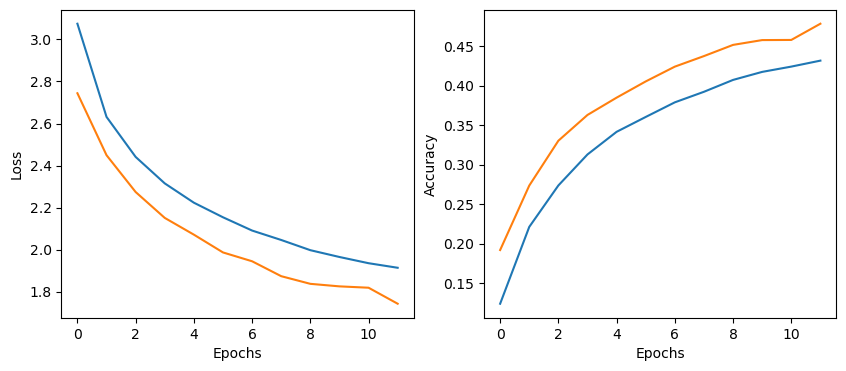

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))
axs[0].plot(loss_hist)
axs[0].plot(test_loss_hist)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].plot(acc_hist)
axs[1].plot(test_acc_hist)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
plt.show()

In [28]:
class LSTM2(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM2, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.fc0 = torch.nn.Linear(input_size * 41, input_size)
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=False, dropout=0.3)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # print(x.shape)
        hidden = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(config['device'])
        cell = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(config['device'])
        # x = x.view(x.shape[0], self.input_size * 41)
        x = x.reshape(x.shape[0], self.input_size * 41)
        # print(x.shape)
        x = self.fc0(x)
        # print(x.shape)
        x = x.view(x.shape[0], 1, self.input_size)
        # print(x.shape)
        out, _ = self.lstm(x, (hidden, cell))
        out = self.fc(out[:, -1, :])
        return out
    
lstm2 = LSTM2(input_size=64, hidden_size=64, num_layers=2, output_size=35).to(config['device'])
summary(lstm2, input_size=(config['batch_size'], 1, 64, 41))


Layer (type:depth-idx)                   Output Shape              Param #
LSTM2                                    [256, 35]                 --
├─Linear: 1-1                            [256, 64]                 168,000
├─LSTM: 1-2                              [256, 1, 64]              66,560
├─Linear: 1-3                            [256, 35]                 2,275
Total params: 236,835
Trainable params: 236,835
Non-trainable params: 0
Total mult-adds (M): 60.63
Input size (MB): 2.69
Forward/backward pass size (MB): 0.33
Params size (MB): 0.95
Estimated Total Size (MB): 3.97

In [30]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm2.parameters(), lr=config['learning_rate'])

# # train
# lstm.train()

transform = torch.nn.Sequential(
    Resample(orig_freq=sr, new_freq=8000),
    MFCC(sample_rate=8000, n_mfcc=64 )
)

loss_hist = []
acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_loss = 9999999
best_acc = 0

for epoch in range(config['epochs']):
    # train
    lstm2.train()
    running_loss = 0.0
    running_acc = 0.0
    for i, (waveform, label) in tqdm(enumerate(train_dataloader)):
        waveform, label = waveform, label.to(config['device'])

        features = transform(waveform)
        features = features.to(config['device'])
        # print(features.shape)
        outputs = lstm2(features)

        # downsampled_waveform = transform(waveform)
        # featuress = get_MFCC(downsampled_waveform, sr=8000, n=64)
        # featuress = featuress.to(config['device'])
        # outputs = lstm(featuress)
        
        loss = criterion(outputs, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        running_acc += (predicted == label).sum().item()

    loss_hist.append(running_loss/len(train_dataloader))
    acc_hist.append(running_acc/len(raw_train_data))
    print(f'Epoch {epoch+1}, Loss: {running_loss}, Acc: {running_acc/len(raw_train_data)}')

    # test
    lstm2.eval()
    running_loss = 0.0
    running_acc = 0.0
    for i, (waveform, label) in tqdm(enumerate(test_dataloader)):
        waveform, label = waveform, label.to(config['device'])
        features = transform(waveform)
        features = features.to(config['device'])
        # print(features.shape)
        outputs = lstm2(features)

        # downsampled_waveform = transform(waveform)
        # featuress = get_MFCC(downsampled_waveform, sr=8000, n=64)
        # featuress = featuress.to(config['device'])
        # outputs = lstm(featuress)
        
        loss = criterion(outputs, label)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        running_acc += (predicted == label).sum().item()

    test_loss_hist.append(running_loss/len(test_dataloader))
    test_acc_hist.append(running_acc/len(raw_test_data))
    print(f'Epoch {epoch+1}, Test Loss: {running_loss}, Test Acc: {running_acc/len(raw_test_data)}')
    if running_loss < best_loss and running_acc > best_acc:
        best_loss = running_loss
        best_acc = running_acc
        torch.save(lstm2.state_dict(), f'{config["save_path"]}/LSTM2.pth')


332it [00:38,  8.54it/s]


Epoch 1, Loss: 1092.7353565692902, Acc: 0.07591669318623812


43it [00:04,  9.10it/s]


Epoch 1, Test Loss: 131.87612581253052, Test Acc: 0.11567469332121763


332it [00:37,  8.79it/s]


Epoch 2, Loss: 1008.1513407230377, Acc: 0.12450054807114318


43it [00:04,  9.19it/s]


Epoch 2, Test Loss: 125.35578489303589, Test Acc: 0.14929577464788732


332it [00:37,  8.76it/s]


Epoch 3, Loss: 971.6178863048553, Acc: 0.15081974941951604


43it [00:04,  9.10it/s]


Epoch 3, Test Loss: 122.36256766319275, Test Acc: 0.1737392094502499


332it [00:38,  8.64it/s]


Epoch 4, Loss: 944.1392459869385, Acc: 0.1685701825725163


43it [00:04,  9.61it/s]


Epoch 4, Test Loss: 120.51230335235596, Test Acc: 0.1838255338482508


332it [00:37,  8.75it/s]


Epoch 5, Loss: 917.127477645874, Acc: 0.18912579706045285


43it [00:05,  8.60it/s]


Epoch 5, Test Loss: 115.29577469825745, Test Acc: 0.20826896865061337


332it [00:37,  8.77it/s]


Epoch 6, Loss: 902.5209963321686, Acc: 0.2011597892578056


43it [00:04,  9.22it/s]


Epoch 6, Test Loss: 114.41552710533142, Test Acc: 0.21190368014538846


332it [00:38,  8.70it/s]


Epoch 7, Loss: 889.1280076503754, Acc: 0.21206227974022607


43it [00:04,  8.88it/s]


Epoch 7, Test Loss: 111.95551776885986, Test Acc: 0.23107678328032713


332it [00:37,  8.92it/s]


Epoch 8, Loss: 872.4530668258667, Acc: 0.22507454946194735


43it [00:04,  8.97it/s]


Epoch 8, Test Loss: 110.29262781143188, Test Acc: 0.24061790095411176


332it [00:37,  8.82it/s]


Epoch 9, Loss: 864.1823036670685, Acc: 0.23238216470421838


43it [00:04,  8.92it/s]


Epoch 9, Test Loss: 106.84557867050171, Test Acc: 0.2619718309859155


332it [00:38,  8.59it/s]


Epoch 10, Loss: 845.8382432460785, Acc: 0.24756314604622656


43it [00:05,  8.48it/s]


Epoch 10, Test Loss: 106.08409023284912, Test Acc: 0.27024079963652886


332it [00:39,  8.43it/s]


Epoch 11, Loss: 836.9163773059845, Acc: 0.25351531652581827


43it [00:04,  8.79it/s]


Epoch 11, Test Loss: 103.42380595207214, Test Acc: 0.2850522489777374


332it [00:37,  8.80it/s]


Epoch 12, Loss: 824.4585475921631, Acc: 0.2671876289145834


43it [00:04,  9.30it/s]


Epoch 12, Test Loss: 101.26731133460999, Test Acc: 0.29532030895047706


332it [00:35,  9.35it/s]


Epoch 13, Loss: 812.7726762294769, Acc: 0.27567389177657553


43it [00:05,  8.39it/s]


Epoch 13, Test Loss: 100.26230454444885, Test Acc: 0.3133121308496138


332it [00:36,  9.19it/s]


Epoch 14, Loss: 805.5128622055054, Acc: 0.28203858892306966


43it [00:04,  9.01it/s]


Epoch 14, Test Loss: 98.70870876312256, Test Acc: 0.3284870513402999


332it [00:37,  8.77it/s]


Epoch 15, Loss: 791.6452925205231, Acc: 0.3000601110286058


43it [00:04,  9.36it/s]


Epoch 15, Test Loss: 99.715500831604, Test Acc: 0.3203089504770559


332it [00:36,  9.07it/s]


Epoch 16, Loss: 779.7010817527771, Acc: 0.3062362245559445


43it [00:04,  9.64it/s]


Epoch 16, Test Loss: 95.8293182849884, Test Acc: 0.3425715583825534


332it [00:35,  9.27it/s]


Epoch 17, Loss: 767.2227671146393, Acc: 0.3171622879907594


43it [00:04,  9.18it/s]


Epoch 17, Test Loss: 94.75911378860474, Test Acc: 0.3598364379827351


332it [00:40,  8.28it/s]


Epoch 18, Loss: 763.8490352630615, Acc: 0.3219829567554188


43it [00:04,  8.86it/s]


Epoch 18, Test Loss: 95.8322389125824, Test Acc: 0.34466151749204904


332it [00:39,  8.38it/s]


Epoch 19, Loss: 759.293016910553, Acc: 0.32647360418655635


43it [00:05,  8.20it/s]


Epoch 19, Test Loss: 93.77520823478699, Test Acc: 0.35774647887323946


332it [00:41,  7.95it/s]


Epoch 20, Loss: 749.1571662425995, Acc: 0.33275579599967


43it [00:05,  7.33it/s]


Epoch 20, Test Loss: 95.52521824836731, Test Acc: 0.34756928668786913


332it [00:41,  7.95it/s]


Epoch 21, Loss: 742.896156668663, Acc: 0.3390969201937697


43it [00:05,  8.32it/s]


Epoch 21, Test Loss: 91.98206675052643, Test Acc: 0.37319400272603365


332it [00:41,  8.06it/s]


Epoch 22, Loss: 746.3108003139496, Acc: 0.3365156819065804


43it [00:05,  8.59it/s]


Epoch 22, Test Loss: 91.37384569644928, Test Acc: 0.3729213993639255


332it [00:39,  8.41it/s]


Epoch 23, Loss: 739.1203620433807, Acc: 0.34626309772167413


43it [00:04,  8.97it/s]


Epoch 23, Test Loss: 90.12282693386078, Test Acc: 0.38464334393457517


332it [00:39,  8.30it/s]


Epoch 24, Loss: 735.4833744764328, Acc: 0.3476774748653395


43it [00:05,  8.44it/s]


Epoch 24, Test Loss: 90.4327654838562, Test Acc: 0.38028169014084506


332it [00:41,  8.05it/s]


Epoch 25, Loss: 723.2509433031082, Acc: 0.35743667715663047


43it [00:04,  8.65it/s]


Epoch 25, Test Loss: 89.71503555774689, Test Acc: 0.38736937755565654


332it [00:38,  8.57it/s]


Epoch 26, Loss: 729.4579864740372, Acc: 0.35082446400999495


43it [00:04,  9.71it/s]


Epoch 26, Test Loss: 89.87407159805298, Test Acc: 0.37910040890504315


332it [00:34,  9.57it/s]


Epoch 27, Loss: 716.207684636116, Acc: 0.3607958228728357


43it [00:06,  7.16it/s]


Epoch 27, Test Loss: 87.40183758735657, Test Acc: 0.40181735574738753


332it [00:35,  9.34it/s]


Epoch 28, Loss: 716.6442754268646, Acc: 0.36177410039720426


43it [00:04,  9.80it/s]


Epoch 28, Test Loss: 87.93359279632568, Test Acc: 0.3988187187641981


332it [00:34,  9.73it/s]


Epoch 29, Loss: 716.6177124977112, Acc: 0.36070153106325803


43it [00:04,  9.36it/s]


Epoch 29, Test Loss: 87.46521019935608, Test Acc: 0.39990913221263064


332it [00:36,  9.09it/s]


Epoch 30, Loss: 714.5423121452332, Acc: 0.3635067123981943


43it [00:04,  9.57it/s]


Epoch 30, Test Loss: 90.13206732273102, Test Acc: 0.3895502044525216


332it [00:37,  8.81it/s]


Epoch 31, Loss: 707.5186805725098, Acc: 0.370519665735535


43it [00:04,  9.47it/s]


Epoch 31, Test Loss: 86.35003793239594, Test Acc: 0.410358927760109


332it [00:35,  9.48it/s]


Epoch 32, Loss: 703.9102767705917, Acc: 0.37323055526089366


43it [00:04,  9.60it/s]


Epoch 32, Test Loss: 86.74243593215942, Test Acc: 0.40463425715583823


332it [00:35,  9.30it/s]


Epoch 33, Loss: 705.3171244859695, Acc: 0.37031929564018246


43it [00:04,  9.67it/s]


Epoch 33, Test Loss: 87.50081062316895, Test Acc: 0.3990004543389368


332it [00:36,  9.12it/s]


Epoch 34, Loss: 703.1640348434448, Acc: 0.37312447697511875


43it [00:04,  8.74it/s]


Epoch 34, Test Loss: 87.15034818649292, Test Acc: 0.4016356201726488


332it [00:36,  9.05it/s]


Epoch 35, Loss: 703.1630504131317, Acc: 0.3730891175465271


43it [00:04,  9.42it/s]


Epoch 35, Test Loss: 85.34820604324341, Test Acc: 0.4173557473875511


332it [00:36,  9.15it/s]


Epoch 36, Loss: 696.250545501709, Acc: 0.38032601393161486


43it [00:04,  9.30it/s]


Epoch 36, Test Loss: 84.07604050636292, Test Acc: 0.426715129486597


332it [00:36,  9.03it/s]


Epoch 37, Loss: 698.658801317215, Acc: 0.37834588593048335


43it [00:04,  9.48it/s]


Epoch 37, Test Loss: 84.8586038351059, Test Acc: 0.4210813266696956


332it [00:37,  8.95it/s]


Epoch 38, Loss: 687.7067254781723, Acc: 0.38876513088881814


43it [00:04,  8.89it/s]


Epoch 38, Test Loss: 84.12111520767212, Test Acc: 0.4198091776465243


332it [00:40,  8.26it/s]


Epoch 39, Loss: 687.7833223342896, Acc: 0.38832903126952134


43it [00:04,  9.33it/s]


Epoch 39, Test Loss: 84.43938791751862, Test Acc: 0.42089959109495684


332it [00:37,  8.92it/s]


Epoch 40, Loss: 691.0664411783218, Acc: 0.38606602783965677


43it [00:04,  9.16it/s]


Epoch 40, Test Loss: 83.82964527606964, Test Acc: 0.4222626079054975


122it [00:13,  8.82it/s]


KeyboardInterrupt: 

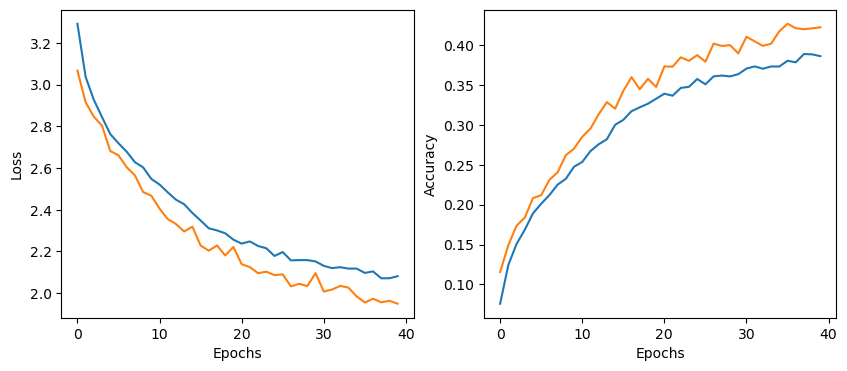

In [31]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))
axs[0].plot(loss_hist)
axs[0].plot(test_loss_hist)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].plot(acc_hist)
axs[1].plot(test_acc_hist)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
plt.show()

# GRU

In [32]:
class GRU(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.fc0 = torch.nn.Linear(input_size * 41, 16)
        self.fc1 = torch.nn.Linear(16, input_size)
        self.gru = torch.nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=False, dropout=0.3)
        # self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=False, dropout=0.3)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # print(x.shape)
        hidden = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(config['device'])
        # x = x.view(x.shape[0], self.input_size * 41)
        x = x.reshape(x.shape[0], self.input_size * 41)
        # print(x.shape)
        x = self.fc0(x)
        x = self.fc1(x)
        # print(x.shape)
        x = x.view(x.shape[0], 1, self.input_size)
        # print(x.shape)
        out, _ = self.gru(x, hidden)
        out = self.fc(out[:, -1, :])
        return out
    
gru = GRU(input_size=64, hidden_size=64, num_layers=2, output_size=35).to(config['device'])
summary(gru, input_size=(config['batch_size'], 1, 64, 41))


Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [256, 35]                 --
├─Linear: 1-1                            [256, 16]                 42,000
├─Linear: 1-2                            [256, 64]                 1,088
├─GRU: 1-3                               [256, 1, 64]              49,920
├─Linear: 1-4                            [256, 35]                 2,275
Total params: 95,283
Trainable params: 95,283
Non-trainable params: 0
Total mult-adds (M): 24.39
Input size (MB): 2.69
Forward/backward pass size (MB): 0.37
Params size (MB): 0.38
Estimated Total Size (MB): 3.43

In [33]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=config['learning_rate'])

# # train
# lstm.train()

transform = torch.nn.Sequential(
    Resample(orig_freq=sr, new_freq=8000),
    MFCC(sample_rate=8000, n_mfcc=64 )
)

loss_hist = []
acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_loss = 9999999
best_acc = 0

for epoch in range(config['epochs']):
    # train
    gru.train()
    running_loss = 0.0
    running_acc = 0.0
    for i, (waveform, label) in tqdm(enumerate(train_dataloader)):
        waveform, label = waveform, label.to(config['device'])

        features = transform(waveform)
        features = features.to(config['device'])
        # print(features.shape)
        outputs = gru(features)

        # downsampled_waveform = transform(waveform)
        # featuress = get_MFCC(downsampled_waveform, sr=8000, n=64)
        # featuress = featuress.to(config['device'])
        # outputs = lstm(featuress)
        
        loss = criterion(outputs, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        running_acc += (predicted == label).sum().item()

    loss_hist.append(running_loss/len(train_dataloader))
    acc_hist.append(running_acc/len(raw_train_data))
    print(f'Epoch {epoch+1}, Loss: {running_loss}, Acc: {running_acc/len(raw_train_data)}')

    # test
    gru.eval()
    running_loss = 0.0
    running_acc = 0.0
    for i, (waveform, label) in tqdm(enumerate(test_dataloader)):
        waveform, label = waveform, label.to(config['device'])
        features = transform(waveform)
        features = features.to(config['device'])
        # print(features.shape)
        outputs = gru(features)

        # downsampled_waveform = transform(waveform)
        # featuress = get_MFCC(downsampled_waveform, sr=8000, n=64)
        # featuress = featuress.to(config['device'])
        # outputs = lstm(featuress)
        
        loss = criterion(outputs, label)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        running_acc += (predicted == label).sum().item()

    test_loss_hist.append(running_loss/len(test_dataloader))
    test_acc_hist.append(running_acc/len(raw_test_data))
    print(f'Epoch {epoch+1}, Test Loss: {running_loss}, Test Acc: {running_acc/len(raw_test_data)}')
    if running_loss < best_loss and running_acc > best_acc:
        best_loss = running_loss
        best_acc = running_acc
        torch.save(lstm2.state_dict(), f'{config["save_path"]}/gru.pth')


332it [00:37,  8.77it/s]


Epoch 1, Loss: 1041.8103721141815, Acc: 0.11541317492309325


43it [00:04,  8.96it/s]


Epoch 1, Test Loss: 119.30943846702576, Test Acc: 0.19000454338936848


332it [00:38,  8.73it/s]


Epoch 2, Loss: 898.7536041736603, Acc: 0.21329985974093324


43it [00:05,  7.88it/s]


Epoch 2, Test Loss: 109.41315412521362, Test Acc: 0.2561562925942753


332it [00:37,  8.82it/s]


Epoch 3, Loss: 847.9203279018402, Acc: 0.25393962966891787


43it [00:04,  9.18it/s]


Epoch 3, Test Loss: 104.90243339538574, Test Acc: 0.28405270331667426


332it [00:38,  8.65it/s]


Epoch 4, Loss: 816.5008397102356, Acc: 0.27879730796883656


43it [00:04,  8.81it/s]


Epoch 4, Test Loss: 101.10857820510864, Test Acc: 0.306133575647433


332it [00:36,  9.07it/s]


Epoch 5, Loss: 801.8542759418488, Acc: 0.28828542130759166


43it [00:04,  9.34it/s]


Epoch 5, Test Loss: 103.57700252532959, Test Acc: 0.2947751022262608


332it [00:38,  8.66it/s]


Epoch 6, Loss: 780.3711078166962, Acc: 0.3105972207489127


43it [00:04,  8.60it/s]


Epoch 6, Test Loss: 96.70878219604492, Test Acc: 0.3392094502498864


332it [00:38,  8.72it/s]


Epoch 7, Loss: 764.5384550094604, Acc: 0.32316160437513997


43it [00:04,  9.44it/s]


Epoch 7, Test Loss: 96.90437769889832, Test Acc: 0.3425715583825534


332it [00:36,  9.00it/s]


Epoch 8, Loss: 754.1104238033295, Acc: 0.33571420152517


43it [00:04,  9.31it/s]


Epoch 8, Test Loss: 93.71781706809998, Test Acc: 0.3613811903680145


332it [00:36,  9.16it/s]


Epoch 9, Loss: 752.2834975719452, Acc: 0.33744681352616007


43it [00:04,  9.43it/s]


Epoch 9, Test Loss: 92.16898000240326, Test Acc: 0.37228532485233984


332it [00:37,  8.82it/s]


Epoch 10, Loss: 742.4582138061523, Acc: 0.3416192260999729


43it [00:04,  9.52it/s]


Epoch 10, Test Loss: 91.6928483247757, Test Acc: 0.37319400272603365


332it [00:36,  9.01it/s]


Epoch 11, Loss: 733.9837913513184, Acc: 0.35128413658168617


43it [00:04,  9.53it/s]


Epoch 11, Test Loss: 91.26301598548889, Test Acc: 0.37719218537028626


332it [00:36,  9.05it/s]


Epoch 12, Loss: 731.4521619081497, Acc: 0.35304032153507064


43it [00:05,  8.27it/s]


Epoch 12, Test Loss: 89.74578022956848, Test Acc: 0.3880054520672422


332it [00:36,  9.20it/s]


Epoch 13, Loss: 721.4675462245941, Acc: 0.3605954527774831


43it [00:03, 10.80it/s]


Epoch 13, Test Loss: 91.16784524917603, Test Acc: 0.3755565651976374


332it [00:32, 10.12it/s]


Epoch 14, Loss: 717.9537045955658, Acc: 0.3641196091604493


43it [00:04, 10.73it/s]


Epoch 14, Test Loss: 88.01620292663574, Test Acc: 0.39454793275783734


332it [00:38,  8.68it/s]


Epoch 15, Loss: 721.6798225641251, Acc: 0.36124370896832975


43it [00:05,  7.95it/s]


Epoch 15, Test Loss: 88.74329423904419, Test Acc: 0.39709223080417994


332it [00:36,  9.04it/s]


Epoch 16, Loss: 721.4635963439941, Acc: 0.3628820291597421


43it [00:04,  9.62it/s]


Epoch 16, Test Loss: 88.1622326374054, Test Acc: 0.40118128123580193


332it [00:36,  9.14it/s]


Epoch 17, Loss: 710.1243315935135, Acc: 0.37042537392595737


43it [00:04,  9.35it/s]


Epoch 17, Test Loss: 87.62718772888184, Test Acc: 0.4045433893684689


332it [00:37,  8.88it/s]


Epoch 18, Loss: 704.9928740262985, Acc: 0.37800407812076425


43it [00:04,  9.22it/s]


Epoch 18, Test Loss: 87.31659686565399, Test Acc: 0.3964561562925943


332it [00:37,  8.89it/s]


Epoch 19, Loss: 702.2028262615204, Acc: 0.3785580425020332


43it [00:04,  8.83it/s]


Epoch 19, Test Loss: 86.2395750284195, Test Acc: 0.41353930031803726


332it [00:37,  8.75it/s]


Epoch 20, Loss: 697.4897266626358, Acc: 0.38360265431443963


43it [00:04,  9.00it/s]


Epoch 20, Test Loss: 86.35681140422821, Test Acc: 0.4133575647432985


332it [00:39,  8.48it/s]


Epoch 21, Loss: 698.3552132844925, Acc: 0.38274224155204317


43it [00:04,  9.87it/s]


Epoch 21, Test Loss: 86.27372765541077, Test Acc: 0.4147205815538392


332it [00:38,  8.59it/s]


Epoch 22, Loss: 689.4616178274155, Acc: 0.39034451869924447


43it [00:04,  9.12it/s]


Epoch 22, Test Loss: 86.01018226146698, Test Acc: 0.41272149023171284


332it [00:38,  8.63it/s]


Epoch 23, Loss: 693.9766367673874, Acc: 0.38611317374444565


43it [00:05,  8.41it/s]


Epoch 23, Test Loss: 85.56664276123047, Test Acc: 0.4187187641980918


332it [00:38,  8.68it/s]


Epoch 24, Loss: 687.0942046642303, Acc: 0.3906863265089636


43it [00:04,  9.28it/s]


Epoch 24, Test Loss: 84.87965619564056, Test Acc: 0.4171740118128124


332it [00:38,  8.56it/s]


Epoch 25, Loss: 691.5673233270645, Acc: 0.3876925615548719


43it [00:04,  9.20it/s]


Epoch 25, Test Loss: 87.83121156692505, Test Acc: 0.4036347114947751


332it [00:37,  8.83it/s]


Epoch 26, Loss: 694.181790471077, Acc: 0.38605424136345956


43it [00:04,  9.62it/s]


Epoch 26, Test Loss: 87.44429957866669, Test Acc: 0.39727396637891865


131it [00:15,  8.69it/s]


KeyboardInterrupt: 

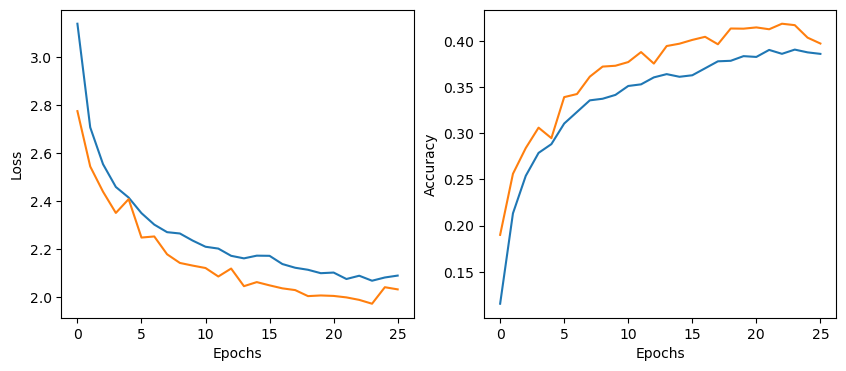

In [34]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))
axs[0].plot(loss_hist)
axs[0].plot(test_loss_hist)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].plot(acc_hist)
axs[1].plot(test_acc_hist)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
plt.show()